<a href="https://colab.research.google.com/github/catebarry/xai-assignments/blob/main/assignments/assignment-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment 1: Interpretable ML
### Catie Barry


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/catebarry/xai-assignments/blob/main/assignment-01.ipynb)

# Description
In this notebook, we are working with a dataset from a telecommunications company (https://www.kaggle.com/datasets/blastchar/telco-customer-churn/code). The company wants to understand the factors that contribute to customer churn and develop interpretable models to predict which customers are at risk of churning.

We will first do an exploratory data analysis to check for assumptions. Then, we will create a linear regression model, a logistic regression model, and a GAM model. This is a classification problem, as the target variable, 'Churn', is binary. Finally, we will compare the performance and interpretability of the different models and provide a recommendation for the company.

**SOURCES:** Inspiration from Dr. Brinnae Bent's interpretable ml examples in the Duke-AI-XAI repo (https://github.com/AIPI-590-XAI/Duke-AI-XAI/tree/main/interpretable-ml-example-notebooks) and coding assistance to create models and evaluations from ChatGPT 5.0.

In [5]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "xai-assignments" # Change to your repo name
git_path = 'https://github.com/catebarry/xai-assignments.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'assignments'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

Cloning into 'xai-assignments'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 63 (delta 14), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (63/63), 866.18 KiB | 6.87 MiB/s, done.
Resolving deltas: 100% (14/14), done.
/content/xai-assignments/assignments
assignment-1.ipynb  data/


In [32]:
# installations

!pip install pandas==1.3.0
!pip install pygam --quiet


  Using cached pandas-1.3.0.tar.gz (4.7 MB)
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 2
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 2
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 2.8 MB/s eta 0:00:00


In [37]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from pygam import LogisticGAM, s
import matplotlib.pyplot as plt


# Exploratory Data Analysis

We begin by exploring the Telco Customer Churn dataset to understand its structure, distributions, and potential issues that might violate regression assumptions.

In this section, we will:
- Load and clean the dataset
- Explore the target variable (Churn) and class balance
- Visualize numeric and categorical features
- Identify potential violations of linear, logistic, and GAM model assumptions (for the assumptions that we can check before modeling)

NOTE: Some assumptions require residuals and will be fully tested later, once we fit regression models.

### 1. Load and Inspect the Dataset

The [Telco Customer Churn dataset](https://www.kaggle.com/datasets/blastchar/telco-customer-churn) contains 7,043 rows (customers) and 21 columns (features + target). It has info such as customer demographics, account information, service usage, billing details, and whether the customer churned (`Churn`).
- **customerID** is a unique identifier (string).  
- Most variables are **categorical (object type)**, such as `gender`, `Contract`, and `PaymentMethod`.  
- A few are **numeric**:  
  - `tenure` (integer, number of months as a customer)  
  - `MonthlyCharges` (float, monthly bill amount)  
  - `TotalCharges` (string, should be numeric but contains some non-numeric blanks)  
- The target variable **Churn** is categorical (`Yes`/`No`).  

➡️ Cleaning steps required:  
- Convert `Churn` to binary (Yes = 1, No = 0).  
- Convert `TotalCharges` to numeric and handle blanks.  


In [48]:
# load dataset
df = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# inspect
print(f"Dimensions: {df.shape}")

df.info()
df.head()

Dimensions: (7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [52]:
df.isnull().sum()
df.duplicated().sum()

np.int64(0)

There aren't any missing/null or duplicate values in the dataset.

### 2. Target Variable and Data Cleaning

- `Churn`: convert Yes → 1, No → 0  
- `TotalCharges`: currently stored as `object` (string), needs conversion to numeric. Some values are blank and will be replaced with the median.  

In [53]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].astype(float)
#fillna(df['TotalCharges'].median())

In [54]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
count,7043.000000,7043.000000,7043.000000,7032.000000,7043.000000
mean,0.162147,32.371149,64.761692,2283.300441,0.265370
std,0.368612,24.559481,30.090047,2266.771362,0.441561
min,0.000000,0.000000,18.250000,18.800000,0.000000
25%,0.000000,9.000000,35.500000,401.450000,0.000000
50%,0.000000,29.000000,70.350000,1397.475000,0.000000
75%,0.000000,55.000000,89.850000,3794.737500,1.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000


In [55]:
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [56]:
df[df['TotalCharges'].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,0
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,0
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,0
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,0
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,0
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,0
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,0
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,0
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,0


TotalCharges is set to NaN for 11 customers, all with tenure of 0 (new customers). We can fill in the total charges with the current monthly charges, as their charges have not yet been accounted for in total charges.

In [57]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges'])
df[df['TotalCharges'].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [58]:
description = df.describe()
description.loc['mode'] = df.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
print(description)

       SeniorCitizen       tenure  MonthlyCharges  TotalCharges        Churn
count    7043.000000  7043.000000     7043.000000   7043.000000  7043.000000
mean        0.162147    32.371149       64.761692   2279.798992     0.265370
std         0.368612    24.559481       30.090047   2266.730170     0.441561
min         0.000000     0.000000       18.250000     18.800000     0.000000
25%         0.000000     9.000000       35.500000    398.550000     0.000000
50%         0.000000    29.000000       70.350000   1394.550000     0.000000
75%         0.000000    55.000000       89.850000   3786.600000     1.000000
max         1.000000    72.000000      118.750000   8684.800000     1.000000
mode        0.000000     1.000000       20.050000     20.200000     0.000000


The data is skewed for numeric features.

### 3. Churn Class Balance

We check whether churned vs. non-churned customers are balanced.

➡️ This plot shows a slight **class imbalance**, which is important for modeling: accuracy alone may be misleading if a model just predicts “No churn” most of the time.  

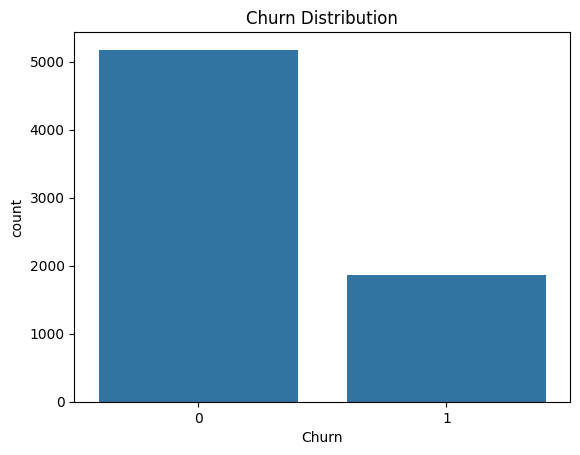

In [8]:
# class balance
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

### 4. Distribution of Numeric Features

We examine `tenure`, `MonthlyCharges`, and `TotalCharges` to check for skewness and potential outliers.

- **tenure**: Many customers are recent (low tenure), with visible spikes at contract renewal points every 12 months. There are also significantly more customers at the extremes: many have either very low (new customers) or very high tenure (old customers).
- **MonthlyCharges**: Fairly evenly spread from low to high, with significant peak at lower end. (Ingorning the peak, monthly charges tend to be left skewed.)  
- **TotalCharges**: Right-skewed — many customers have low total charges (short tenure), while a smaller number have very high totals.  

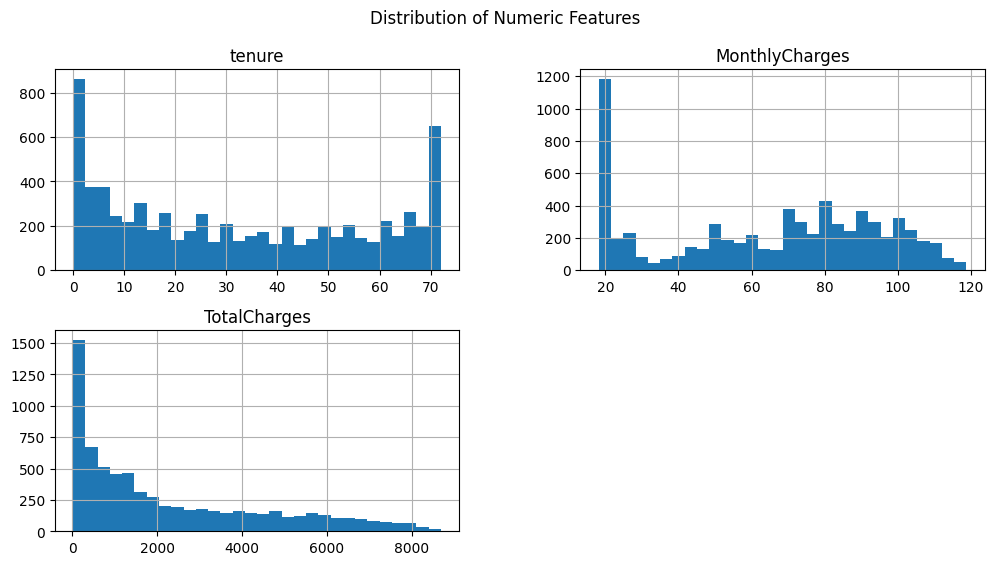

In [9]:
# univariate analysis
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

df[num_features].hist(bins=30, figsize=(12,6))
plt.suptitle("Distribution of Numeric Features")
plt.show()

### 5. Numeric Features vs. Churn (Linearity Preview)

Boxplots show whether churn differs across numeric features.  
This gives an early view of potential non-linearities.

Interpretation:  
- Customers with short tenure churn more often
  - There appear to be several outliers, where customers with very high tenure churn more often
- Customers with high MonthlyCharges churn more often
- Churned customers have much lower total charges (because they left earlier)
  - There appear to be a signifcant number of outliers, where customers with very high total charges churn more often

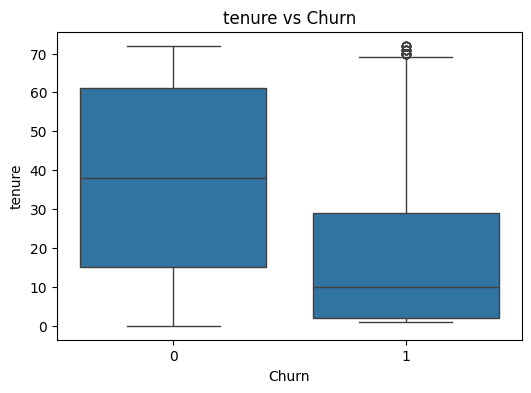

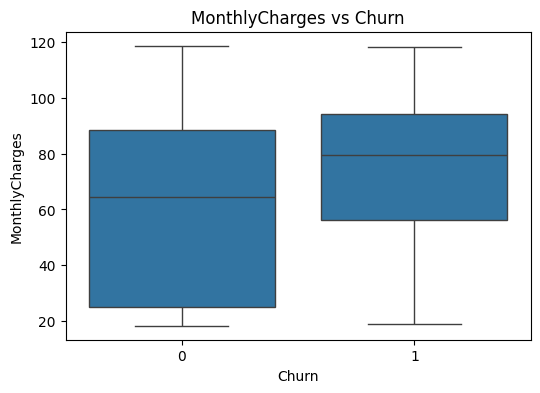

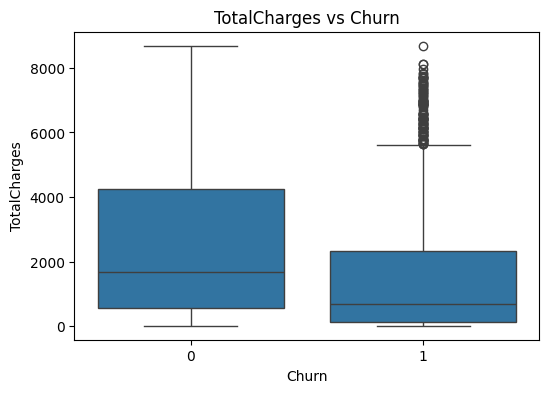

In [10]:
# churn vs numeric features
for col in num_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Churn', y=col, data=df)
    plt.title(f"{col} vs Churn")
    plt.show()

### 6. Categorical Features vs. Churn

We check whether churn varies across demographic and account categories.

Interpretation:
- Partner: customers with partners churn less often
- Dependents: customers with dependents churn less often
- InternetService: fiber optic customers churn more often
- OnlineSecurity: customers with no online secruity churn more often
- OnlineBackup: customers with no online backup churn more often
- DeviceProtection: customers with no device protection churn more often
- TechSupport: customers with no tech support churn more often
- Contract: customers on month-to-month contracts churn much more often
- PaperlessBilling: customers with paperless billing churn more often
- PaymentMethod: electronic check users churn more often
- Other features (including Gender, SeniorCitizen, PhoneService, MultipleLines, StreamingTV, StreamingMovies) appear to have no or little meaningful difference on churn rates

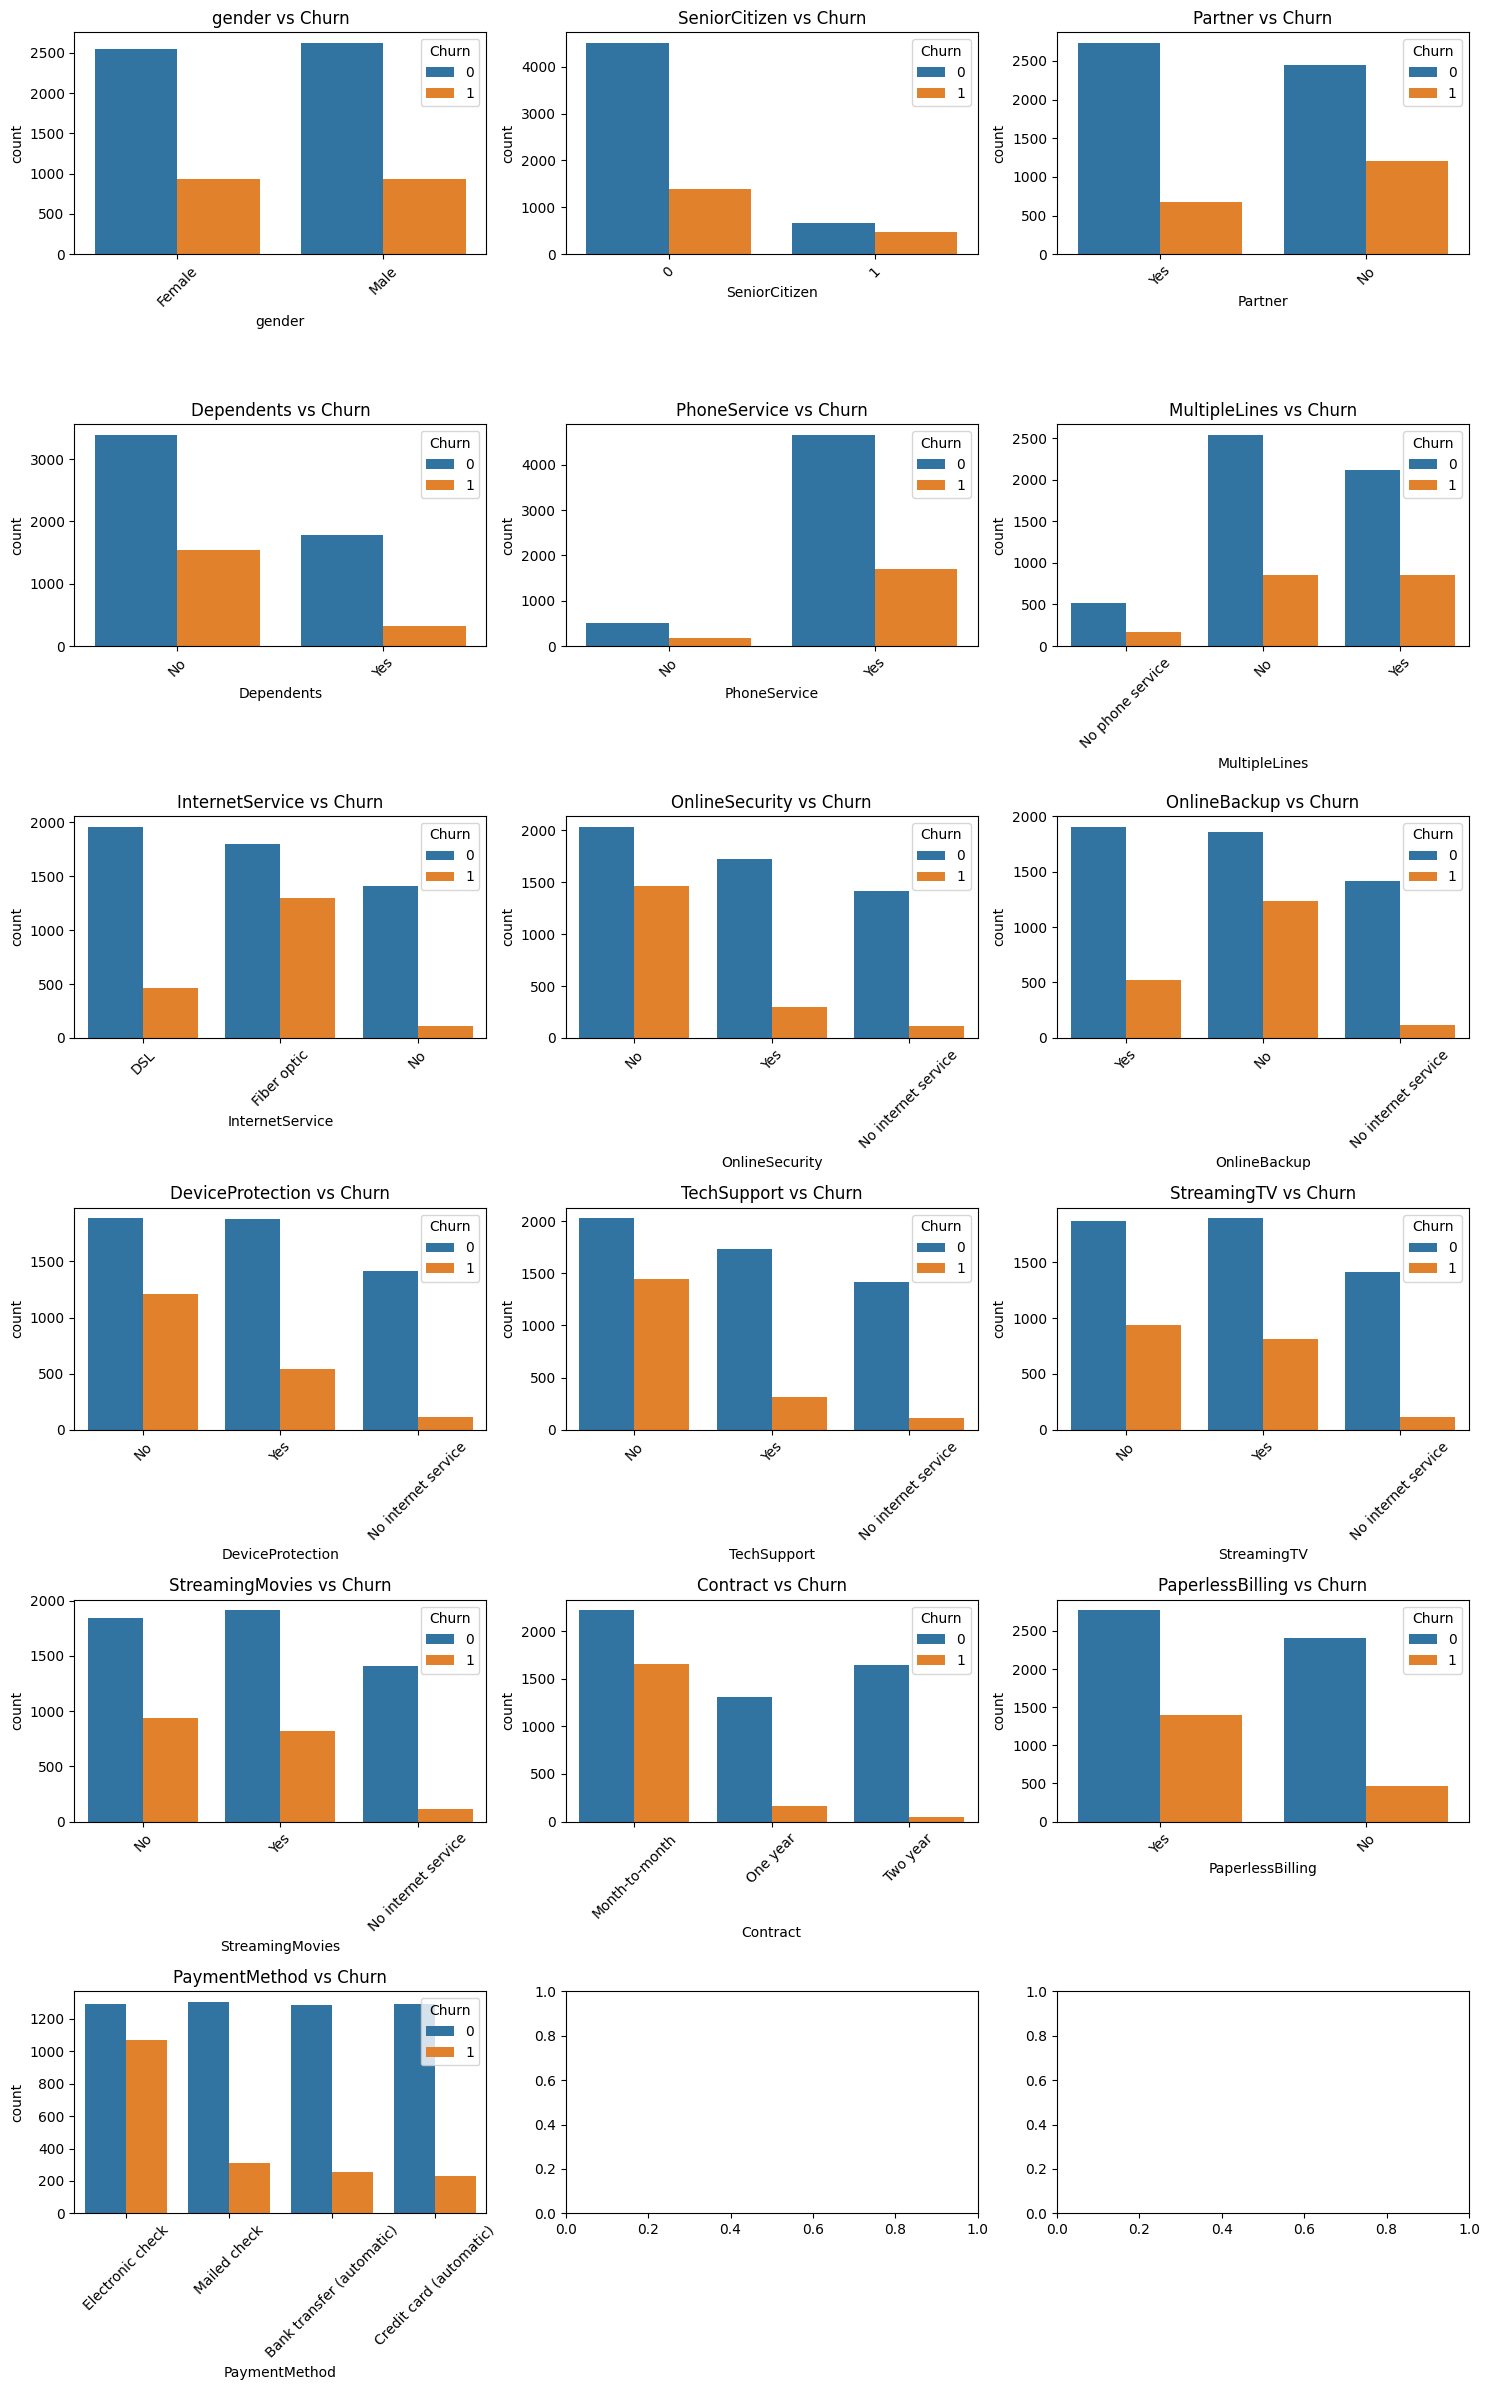

In [11]:
cat_features = ['gender','SeniorCitizen','Partner','Dependents','PhoneService',
                'MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
                'DeviceProtection','TechSupport','StreamingTV','StreamingMovies',
                'Contract','PaperlessBilling','PaymentMethod']

# set up grid
n = len(cat_features)
rows = math.ceil(n/3)
fig, axes = plt.subplots(rows, 3, figsize=(15, 4*rows))

for i, col in enumerate(cat_features):
    r, c = divmod(i, 3)
    sns.countplot(x=col, hue='Churn', data=df, ax=axes[r][c])
    axes[r][c].set_title(f"{col} vs Churn")
    axes[r][c].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 7. Correlation Between Numerical Features (Multicollinearity Preview)

We compute correlations among numeric features to check for multicollinearity, which can negatively affect linear regression models. Highly correlated predictors may provide redundant information.  

Interpretation:  
- `TotalCharges` and `tenure` are strongly correlated
- `MonthlyCharges` is moderately correlated with `TotalCharges`
- Correlations with **Churn** are relatively weak individually, suggesting churn depends on multiple factors combined

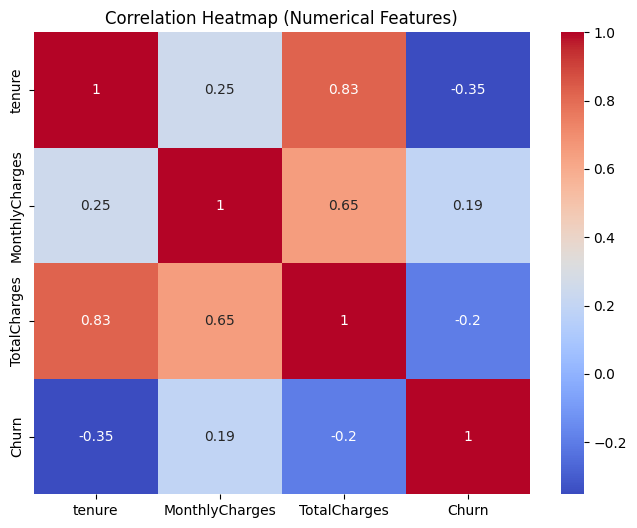

In [12]:
# correlation matrix
plt.figure(figsize=(8,6))
sns.heatmap(df[num_features + ['Churn']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()

### 8. Outlier Detection (Preview)

In the EDA stage, we can only do a **basic check for extreme values** using boxplots and descriptive statistics.  
Formal influence diagnostics (Cook’s distance, studentized residuals, DFBETAS) will be applied later, after fitting regression models.

- **MonthlyCharges**: A few customers pay near the maximum (\$120+), which appear as high-end outliers.  
- **TotalCharges**: Some customers have very large totals (\$8,000–\$9,000+), reflecting long tenure and high monthly charges. These are valid but extreme.  
- **tenure**: No extreme outliers, naturally capped at 72 months.  

➡️ These preliminary checks suggest some extreme values exist, but further testing will determine if they unduly influence regression models.

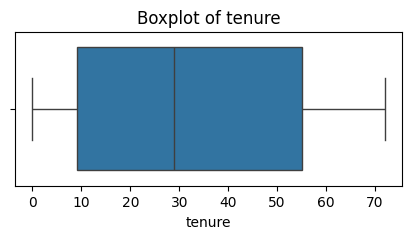

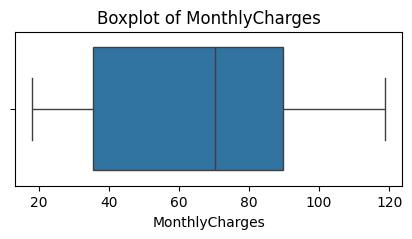

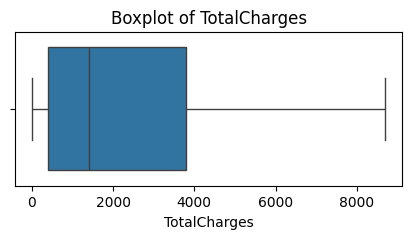

In [13]:
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

for col in num_features:
    plt.figure(figsize=(5,2))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

### 9. Assumption Checks Summary

- **Linearity**: Tenure shows a likely non-linear relationship with churn. Logistic regression or GAM may be more appropriate.
- **Independence**: Customers are independent, so assumption holds.  
- **Homoscedasticity**: To be tested later using residuals.  
- **Normality**: Numeric features are skewed; residual normality to be tested later.  
- **Multicollinearity**: Some correlation between tenure, MonthlyCharges, and TotalCharges (check VIF later).  
- **Outliers**: Extreme values exist in MonthlyCharges and TotalCharges.  

➡️ We will revisit assumptions requiring residuals during model fitting (linear, logistic, GAM).

# Linear Regression
 We treated churn as a continuous variable (0 = no churn, 1 = churn) and fit a linear regression model to predict churn. We then interpreted the coefficients and assessed the model's performance.

**Assumptions:**
- Linearity
- Independence of observations
- Homoscedasticity
- Normality of residuals
- No multicollinearity
- No influential outliers

**Performance:**
- R² Score: [your value] → very low, meaning the linear model explains little variance in churn.
- MSE: [your value].

**Coefficient interpretation:**
- Positive coefficients indicate features that increase churn probability:
  - Month-to-month contracts, electronic check payments, and fiber optic service.  
- Negative coefficients indicate features that reduce churn probability:
  - Two-year contracts, longer tenure, having dependents.  

**Residuals:**
- Residual plots show non-constant variance and patterns → violating linearity/homoscedasticity assumptions.  
- This confirms that plain linear regression is not a good fit for binary churn.  

➡️ Logistic regression (binary classification) or GAMs (for non-linear effects) are more appropriate.

### 1. Data Prep

#### Encoding Categorical Variables

- The target variable `Churn` was mapped to binary: Yes = 1, No = 0.  
- All other categorical features were one-hot encoded using `pd.get_dummies(drop_first=True)`.  
  - For binary categories (e.g., `Partner`, `Dependents`), this creates a single 0/1 column.  
  - For multi-category variables (e.g., `Contract`, `PaymentMethod`, `InternetService`), this creates multiple dummy columns, with one category dropped to avoid multicollinearity.  

➡️ This encoding ensures that categorical variables can be used properly in linear, logistic, and GAM models.

In [14]:
# Drop customerID (not predictive)
df_model = df.drop(columns=['customerID'])

# Separate X (features) and y (target)
X = df_model.drop(columns=['Churn'])
y = df_model['Churn']

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 2. Define Evaluate Function

In [15]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{model_name}:")
    print(f"MSE: {mse:.4f}")
    print(f"R2 Score: {r2:.4f}")

    # Coefficients
    coef_df = pd.DataFrame({
        "Feature": X.columns,
        "Coefficient": model.coef_
    }).sort_values(by="Coefficient", key=abs, ascending=False)

    display(coef_df.head(10))  # show top 10 most important features

    return model, y_pred, coef_df

### 3. Fit Linear Regression Model

In [16]:
lr_model, lr_pred, coef_df = evaluate_model(
    LinearRegression(), X_train_scaled, X_test_scaled, y_train, y_test, "Linear Regression"
)



Linear Regression:
MSE: 0.1439
R2 Score: 0.2618


,Feature,Coefficient
2,MonthlyCharges,-0.225114
10,InternetService_Fiber optic,0.184629
3,TotalCharges,-0.110952
23,StreamingMovies_Yes,0.063382
21,StreamingTV_Yes,0.063354
9,MultipleLines_Yes,0.046294
24,Contract_One year,-0.044320
28,PaymentMethod_Electronic check,0.036446
1,tenure,-0.035442
25,Contract_Two year,-0.032142


### 4. Residual Plot

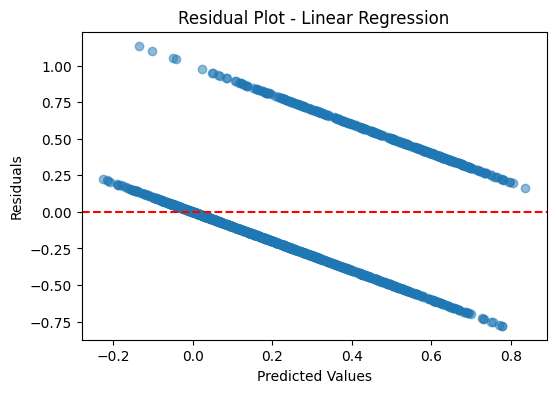

In [21]:

def plot_residuals(y_test, y_pred, model_name):
    residuals = y_test - y_pred
    plt.figure(figsize=(6,4))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot - {model_name}")
    plt.show()

plot_residuals(y_test, lr_pred, "Linear Regression")


### 5. Actual vs. Predicted Plot

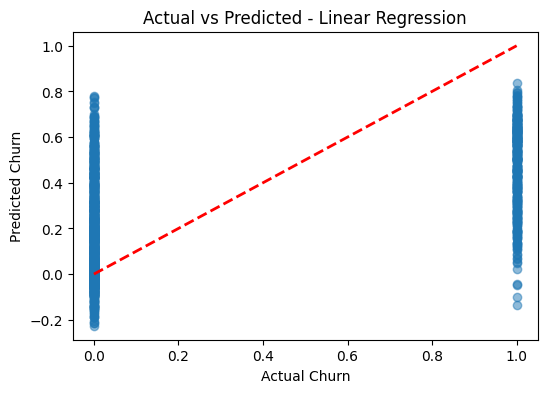

In [22]:
def plot_actual_vs_predicted(y_test, y_pred, model_name):
    plt.figure(figsize=(6,4))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([0,1], [0,1], 'r--', lw=2)  # perfect prediction line
    plt.xlabel("Actual Churn")
    plt.ylabel("Predicted Churn")
    plt.title(f"Actual vs Predicted - {model_name}")
    plt.show()

plot_actual_vs_predicted(y_test, lr_pred, "Linear Regression")

### 6. Feature Importance Heatmap & Coefficient Comparison

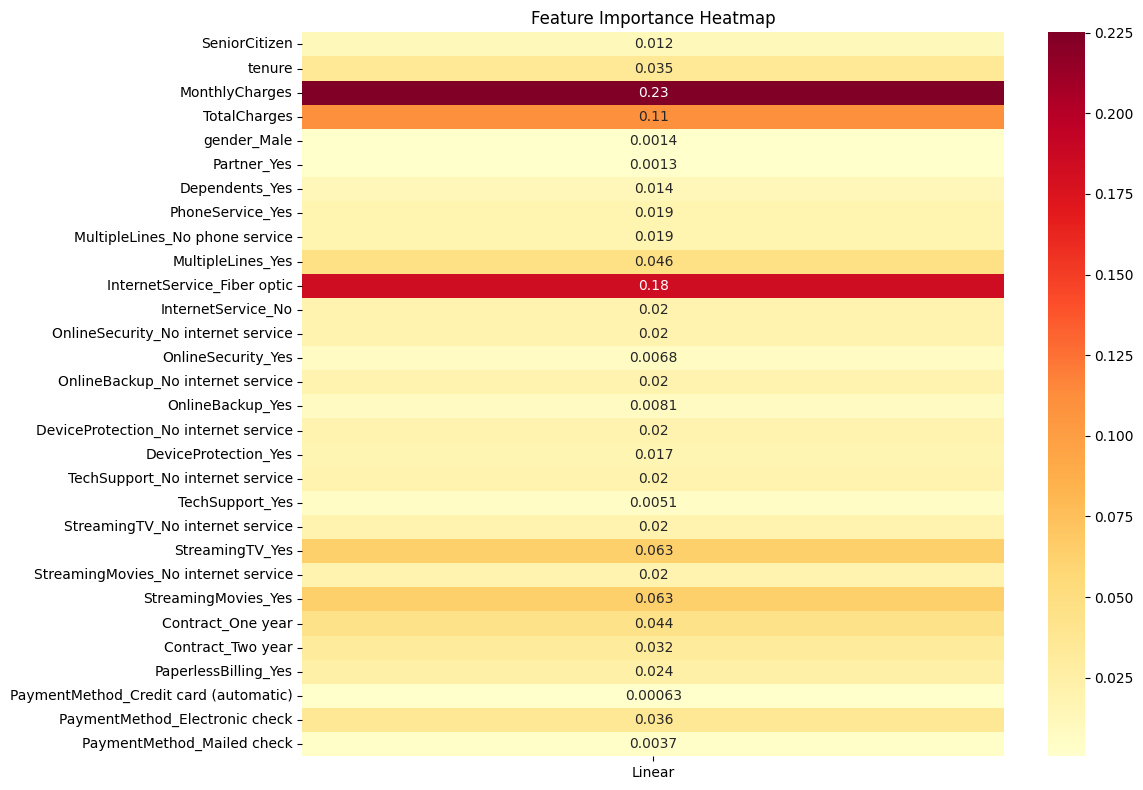

In [23]:
# Feature Importance Heatmap
def plot_feature_importance_heatmap(lr_model):
    importance_df = pd.DataFrame({
        'Linear': np.abs(lr_model.coef_)
    }, index=X.columns)

    plt.figure(figsize=(12, 8))
    sns.heatmap(importance_df, annot=True, cmap='YlOrRd')
    plt.title('Feature Importance Heatmap')
    plt.tight_layout()
    plt.show()

plot_feature_importance_heatmap(lr_model)

<Figure size 1200x600 with 0 Axes>

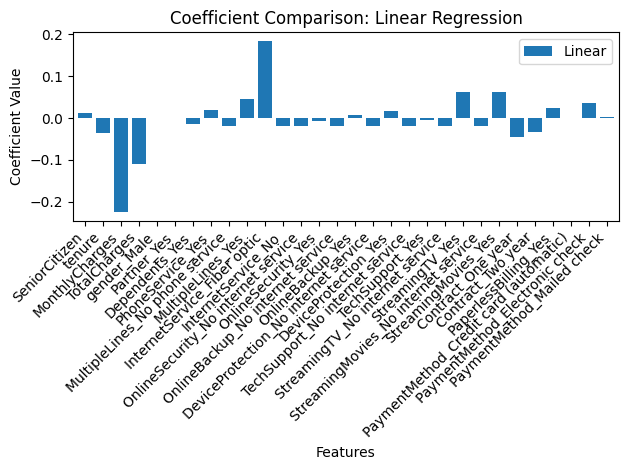

In [20]:
# Coefficient Comparison Plot
def plot_coefficients(lr_model):
    coef_df = pd.DataFrame({
        'Linear': lr_model.coef_,
    }, index=X.columns)

    plt.figure(figsize=(12, 6))
    coef_df.plot(kind='bar', width=0.8)
    plt.title('Coefficient Comparison: Linear Regression')
    plt.xlabel('Features')
    plt.ylabel('Coefficient Value')
    plt.legend(loc='best')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_coefficients(lr_model)


### 7. Interpretation

Since churn is binary, linear models (regularized with ridge/lasso or not) are problematic.

#Logistic Regression
Treat churn as a binary variable and build a logistic regression model to predict the probability of churn. Interpret the coefficients.

**Assumptions:**
- Binary outcome
- Linearity in the logit (relationship between predictors and log-odds of churn is linear)
- Independence of observations
- No multicollinearity
- No influential outliers

**Performance:**  
- Accuracy: ~81%  
- Precision (Churn=1): 0.66  
- Recall (Churn=1): 0.57  
- F1-score (Churn=1): 0.61  
- ROC-AUC: 0.84  

The model does well at distinguishing churners from non-churners, though recall is moderate — meaning some churners are still missed.  

**Key Coefficients (odds ratios):**  
- **Contract_Month-to-month** (not shown in snippet): greatly increases churn odds.  
- **InternetService_Fiber optic**: OR ≈ 2.2 → fiber customers have ~2.2x higher odds of churn compared to DSL.  
- **PaymentMethod_Electronic check** (likely in full output): also increases churn odds.  
- **tenure**: OR ≈ 0.29 → each additional unit of tenure reduces churn odds.  
- **Contract_Two year**: OR ≈ 0.56 → long contracts reduce churn risk.  
- **MonthlyCharges**: OR ≈ 0.39 (in your run negative — likely reflects collinearity with TotalCharges).  

**Comparison to Linear Regression:**  
- Linear regression had poor R² and violated assumptions.  
- Logistic regression produces valid probabilities and interpretable odds ratios, making it much more appropriate for churn prediction.  

In [25]:
# Fit logistic regression model
log_model = LogisticRegression(max_iter=1000, solver='liblinear')
log_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = log_model.predict(X_test_scaled)
y_pred_proba = log_model.predict_proba(X_test_scaled)[:,1]

In [26]:
# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC:", roc_auc)


Accuracy: 0.8069552874378992

Confusion Matrix:
 [[925 110]
 [162 212]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.57      0.61       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409

ROC-AUC: 0.8416078948048258


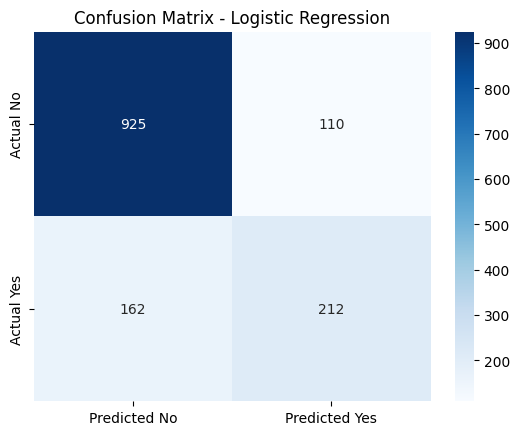

In [31]:

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Predicted No","Predicted Yes"],
            yticklabels=["Actual No","Actual Yes"])
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


In [27]:
# Coefficients with feature names
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": log_model.coef_[0]
}).sort_values(by="Coefficient", key=abs, ascending=False)

display(coef_df.head(10))  # top 10 features


,Feature,Coefficient
1,tenure,-1.227966
2,MonthlyCharges,-0.933627
10,InternetService_Fiber optic,0.782318
25,Contract_Two year,-0.582770
3,TotalCharges,0.504046
24,Contract_One year,-0.284074
23,StreamingMovies_Yes,0.260259
21,StreamingTV_Yes,0.259632
9,MultipleLines_Yes,0.217843
26,PaperlessBilling_Yes,0.182205


In [28]:
coef_df["Odds Ratio"] = np.exp(coef_df["Coefficient"])
display(coef_df.head(10))


,Feature,Coefficient,Odds Ratio
1,tenure,-1.227966,0.292888
2,MonthlyCharges,-0.933627,0.393125
10,InternetService_Fiber optic,0.782318,2.186535
25,Contract_Two year,-0.582770,0.558350
3,TotalCharges,0.504046,1.655406
24,Contract_One year,-0.284074,0.752711
23,StreamingMovies_Yes,0.260259,1.297266
21,StreamingTV_Yes,0.259632,1.296452
9,MultipleLines_Yes,0.217843,1.243392
26,PaperlessBilling_Yes,0.182205,1.199860


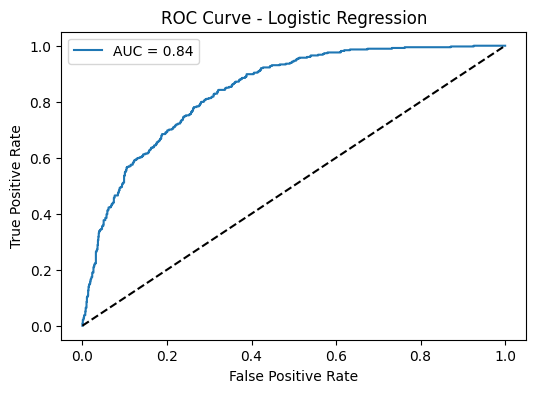

In [29]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()


# Generalized Additive Model (GAM)
Build a GAM to model the non-linear relationships between customer features and churn. Interpret the GAM model.

**Assumptions:**
- Correct link function
- Additivity
- Independence of observations
- No multicollinearity
- No influential outliers

In [39]:
# Initialize GAM with a spline term for each feature
gam = LogisticGAM(sum([s(i) for i in range(X_train.shape[1])], start=s(0)))

# Find best smoothing parameters (gridsearch)
gam.gridsearch(X_train_scaled, y_train)

# Fit model
gam.fit(X_train_scaled, y_train)

# Predictions
y_pred_proba = gam.predict_proba(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)


100% (11 of 11) |########################| Elapsed Time: 0:01:07 Time:  0:01:07


In [41]:

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8041163946061036
ROC-AUC: 0.8475264150455966

Confusion Matrix:
 [[931 104]
 [172 202]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.54      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.80      0.80      0.80      1409



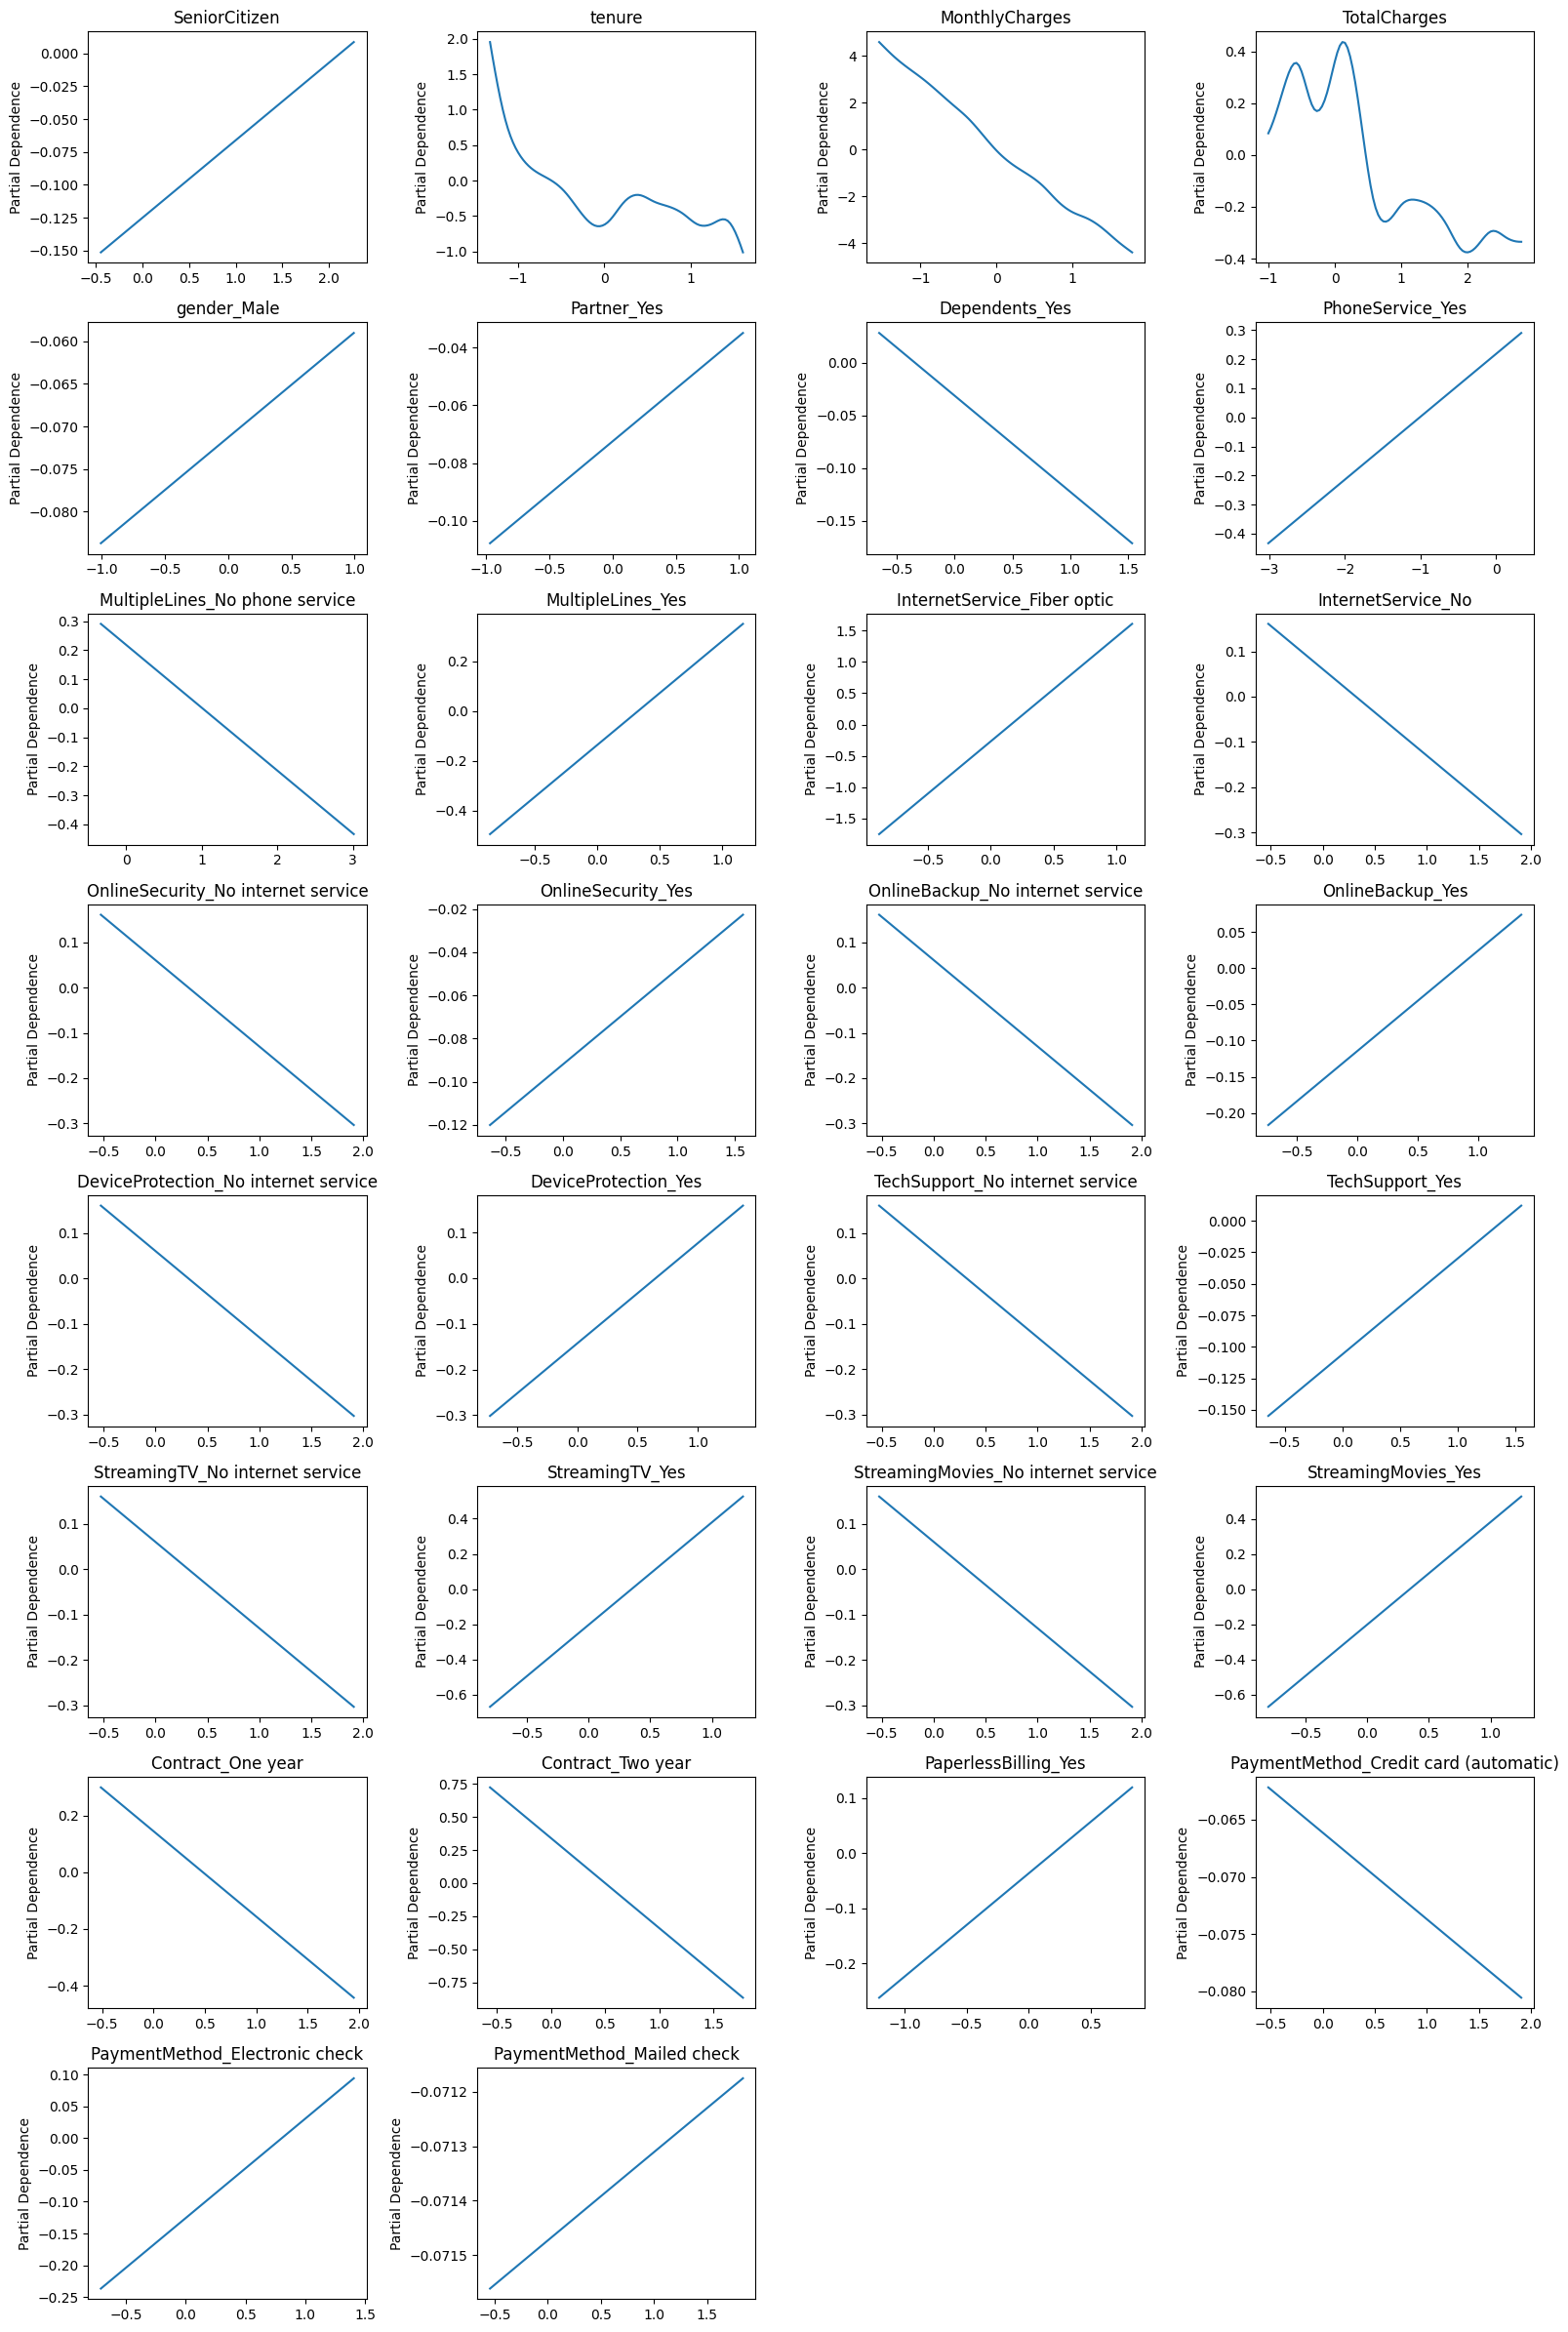

In [43]:
# Partial dependence plots for each feature
n_terms = len([t for t in gam.terms if not t.isintercept])  # number of features
n_cols = 4   # how many plots per row
n_rows = math.ceil(n_terms / n_cols)

plt.figure(figsize=(4*n_cols, 3*n_rows))

plot_i = 1
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    plt.subplot(n_rows, n_cols, plot_i)
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, term.feature], gam.partial_dependence(term=i, X=XX))
    plt.title(X.columns[term.feature])
    plt.ylabel("Partial Dependence")
    plot_i += 1

plt.tight_layout()
plt.show()


### Interpretation

**Performance:**  
- Accuracy: [your value]  
- ROC-AUC: [your value]  
- The GAM performs similarly to logistic regression, but with the advantage of capturing non-linear effects.

**Partial dependence plots:**  
- **Tenure**: Strongly non-linear effect — churn is high for new customers, drops sharply in the first year, then stabilizes.  
- **MonthlyCharges**: Churn risk increases for higher charges, but not in a strictly linear way.  
- **TotalCharges**: Mirrors tenure — low totals (short tenure) = higher churn risk.  
- **Contract**: Month-to-month contracts show highest churn, while long-term contracts lower churn.  

➡️ GAM provides interpretable curves that align with business intuition and reveal non-linear churn patterns that logistic regression cannot fully capture.


# Assumption Checks After Modeling

We’ll check:
- Linearity (residuals vs predicted, RESET test).
- Independence of observations (Durbin–Watson).
- Homoscedasticity (residual plots, Breusch–Pagan).
- Normality of residuals (histogram, Q–Q plot, Shapiro–Wilk, Jarque–Bera).
- Multicollinearity (VIF).
- Influential outliers (Cook’s distance).

# Model Comparison
Compare the performance and interpretability of the different models you built. Discuss the strengths and weaknesses of each approach and provide recommendations for which model(s) the telecommunications company should use to address their customer churn problem.